In [1]:
# from __future__ import division, print_function, absolute_import
%matplotlib inline
import numpy as np

from phidl import Device, Layer, LayerSet, make_device
from phidl import quickplot as qp # Rename "quickplot()" to the easier "qp()"
import phidl.geometry as pg
import phidl.routing as pr
import phidl.utilities as pu

import gdspy
# import customed geolib
%copy ..\photonic.py
import photonic as ph
import matplotlib.pyplot as plt

        1 file(s) copied.


In [3]:
# taper extending for dicing
def dic_taper(port, # port to extend
              length=10, 
              width1=3, # width at port
              width2=1, # end width
              dicL = 4, # length to dice with width2
              layer=0):
    D = Device('dic_taper')
    TP = D << pg.taper(port=port,length=length,width1=width1,width2=width2,layer=layer)
    DIC = D << pg.taper(port=TP.ports[2],length=dicL, width1=width2,width2=width2,layer=layer)
    return D

def ext_allpass(width_rg=1, width_bus=1, radius=30, gap=0.1,lenL=10,lenR=10 ,layer = 0):
    D = Device('ext_allpass')
    RG = D << pg.ring(radius=radius,width=width_rg, angle_resolution=.1,layer = layer)
    BUS = D << ph.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus,layer = layer).movex(-radius-(width_rg)/2-lenL)
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D

def ext_fourport(width_rg=2, width_bus=1, radius=30, gap1=0.1, gap2=0.1, 
           extL = 100, layer=0):
    D = Device('ext_fourport')
    RG = D << ph.fourport(width_bus=width_bus,width_rg=width_rg,radius=radius, layer=layer)
    RG.ymin = -width_bus*.5

    TP1 = D << pg.taper(port=RG.ports[3],length=radius,width1=width_bus,width2=0,layer=layer)
    
    CN1 = D << pg.connector((TP1.xmax,4*radius),width=width_bus,orientation=0)
    RT1 = D << pr.route_manhattan180(port1=CN1.ports[2],port2=RG.ports[4],layer=layer, radius=.9*radius)

    ET1 = D << pg.taper(port=RG.ports[1],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    ET2 = D << pg.taper(port=RG.ports[2],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    ET3 = D << pg.taper(port=ET2.ports[2],length=extL,width1=width_bus,width2=width_bus,layer=layer)
    
    D.add_port(name=1, midpoint = (D.xmin,width_bus/2), width = width_bus, orientation = 180)
    D.add_port(name=2, midpoint = (D.xmax,width_bus/2), width = width_bus, orientation = 0)
    D.add_port(name=3, midpoint = (D.xmax,D.ymax-width_bus/2), width = width_bus, orientation = 0)

    return D.flatten()


def cus_die(
              size = (10000, 10000),
              street_width = 100,
              street_length = 1000,
              die_name = 'chip99',
              text_size = 100,
              text_location = 'SW',
              layer = 0,
              draw_bbox = True,
              bbox_layer = 99,
              ):

    #==========================================================================
    #  Create the basic geometry
    #==========================================================================
    D = Device(name = 'die')
    xpts = np.array([size[0]/2, size[0]/2, size[0]/2-street_width, size[0]/2-street_width, size[0]/2-street_length, size[0]/2-street_length])
    ypts = np.array([size[1]/2, size[1]/2-street_length, size[0]/2-street_length, size[0]/2-street_width, size[0]/2-street_width, size[1]/2])
    D.add_polygon([xpts,ypts], layer = layer)
    D.add_polygon([-xpts,ypts], layer = layer)
    D.add_polygon([xpts,-ypts], layer = layer)
    D.add_polygon([-xpts,-ypts], layer = layer)

    if draw_bbox is True:
        s = np.array(size)/2
        D.add_polygon([[s[0],s[1]], [s[0],-s[1]],[-s[0],-s[1]],[-s[0],s[1]]], layer = bbox_layer)
    D.center = (0,0)
    t = D.add_ref(pg.text(text = die_name, size = text_size, layer=layer))

    d = street_width + 500
    sx, sy = size[0]/2, size[1]/2
    if type(text_location) is str:
        if text_location.upper() == 'NW':
            t.xmin, t.ymax = [-sx + d, sy - d]
        elif text_location.upper() == 'N':
            t.x, t.ymax = [0, sy - d]
        elif text_location.upper() == 'NE':
            t.xmax, t.ymax = [sx - d, sy - d]
        if text_location.upper() == 'SW':
            t.xmin, t.ymin = [-sx + d, -sy + d]
        elif text_location.upper() == 'S':
            t.x, t.ymin = [0, -sy + d]
        elif text_location.upper() == 'SE':
            t.xmax, t.ymin = [sx - d, -sy + d]
    else:
        t.x, t.y = text_location

    return D

In [16]:
WG_LAY = 1
TP_LAY = 2
LB_LAY = 3
MK_LAY = 4

DIC = 8e2
cellSize = np.array((10e3,10e3))
cellH, cellW = cellSize

# taper length & taper width, width of bus -> width of taper
lTp = 500
wTp = .9

gcp = {'num_periods': 20,
       'period': 0.6, 
       'fill_factor': 0.5, 
       'angle': 45, 
       'length_taper': 10, 
       'width': 1.5, 
       'layer': TP_LAY}

## allpass mrr

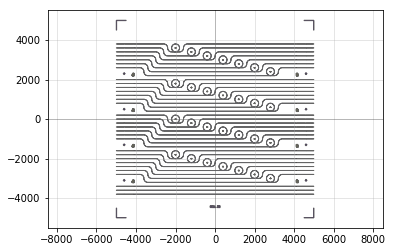

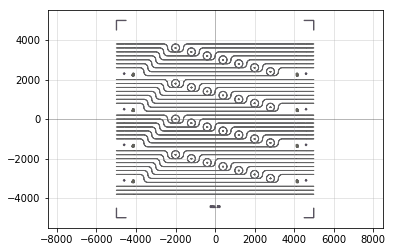

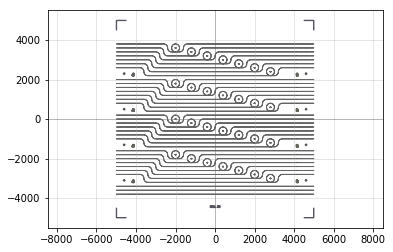

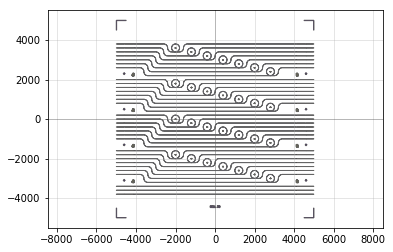

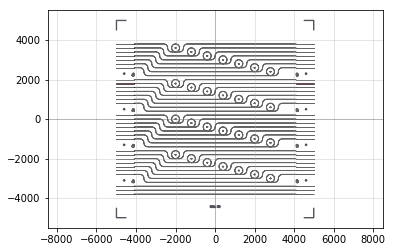

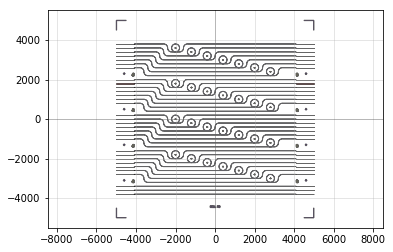

In [17]:
for xx in range(3):
    for yy in range(2):
        wBus = 1.5
        CELL_NUM = 22+10*xx+yy
        wTp = .3 + xx*.6
        cellGDS = Device(f'cell{CELL_NUM}')

        # sweep the ring width between groups of devices

        devLen = cellW-DIC-2*lTp

        # ring radius
        rRg = 200

        # horizontal and vertical dist. per device
        HD = 4*rRg
        VD = rRg

        gpNum  = 4
        gapPeriod = .05

        for k in range(gpNum):

            wRg = 2.0 + .8*yy + .2*k    

            devNum = 7 # num of MRR dev

            # x-axis shift
            offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

            D = Device(f'GP{k}')
            LB = Device(f'LB{k}')

            for i in range(devNum):
                gap = gapPeriod*i+0.1
                MRR = D << ext_allpass(width_bus=wBus,
                                   width_rg=wRg,radius=rRg,
                                   gap=gap,
                                   lenL=i*HD+i*rRg,
                                   lenR=0,
                                  layer=WG_LAY).move((offset+HD*i,-VD*i))
                LB << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

                # tp port
                CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
                CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

                TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)

            #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
                RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                              bendType='circular',radius=rRg,layer=WG_LAY)

            markNum = 1
            markDist = 300
            markSize = 100
            markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -1.5*rRg))
            markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp:.1f}', 
                              layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp:.1f}', 
                              layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-1.5*rRg))
            D << LB
            cellGDS << D.flatten().movey(VD*(devNum+2)*k)

        def BAR():
            D = Device('BAR')
            wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
            tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            return D.flatten()

        for i in range(3):
            cellGDS << pg.copy(BAR()).movey(-i*VD-1.6e3)


        cellGDS.move(-cellGDS.center)

        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

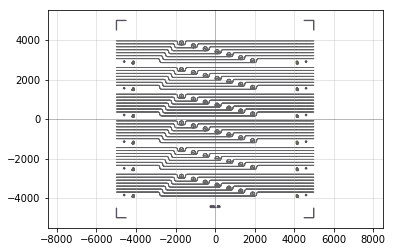

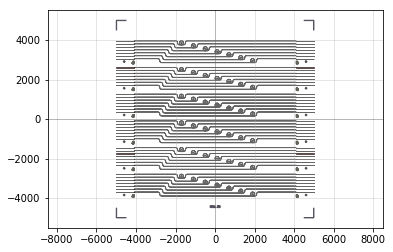

In [19]:
# aa
for yy in range(2):
    CELL_NUM = 24 + yy
    wTp = .9 + yy*.6

    wBus = 1.5
    cellGDS = Device(f'cell{CELL_NUM}')

    # sweep the ring width between groups of devices

    devLen = cellW-DIC-2*lTp

    # ring radius
    rRg = 100

    # horizontal and vertical dist. per device
    HD = 1.5*4*rRg
    VD = 1.5*rRg

    gpNum  = 6
    gapPeriod = .05

    for k in range(gpNum):

        wRg = 1.5 + .2*k    

        devNum = 7 # num of MRR dev

        # x-axis shift
        offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

        D = Device(f'GP{k}')
        LB = Device(f'LB{k}')

        for i in range(devNum):
            gap = gapPeriod*i+0.1
            MRR = D << ext_allpass(width_bus=wBus,
                               width_rg=wRg,radius=rRg,
                               gap=gap,
                               lenL=i*HD+i*1.5*rRg,
                               lenR=0,
                              layer=WG_LAY).move((offset+HD*i,-VD*i))
            LB << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', 
                          size=8, layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

            # tp port
            CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
            CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

            TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
            TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)

        #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
            RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                          bendType='circular',radius=rRg,layer=WG_LAY)
            RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                          bendType='circular',radius=rRg,layer=WG_LAY)

        markNum = 1
        markDist = 300
        markSize = 100
        markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -1.5*rRg))
        markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -1.5*rRg))
        LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
                          layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-1.5*rRg))
        LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
                          layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-1.5*rRg))
        D << LB
        cellGDS << D.flatten().movey(VD*(devNum+2)*k)

    def BAR():
        D = Device('BAR')
        wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
        tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
        tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
        return D.flatten()

#     for i in range(3):
#         cellGDS << pg.copy(BAR()).movey(-2*i*VD-1.3e3)


    cellGDS.move(-cellGDS.center)

    cellGDS <<  cus_die(size=cellSize, text_size=100,
                             street_length=500, 
                             street_width=20, text_location='S',
                             die_name=f'CELL {CELL_NUM}',
                             draw_bbox=False,
                             layer=MK_LAY)
    qp(cellGDS)
    cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## three port

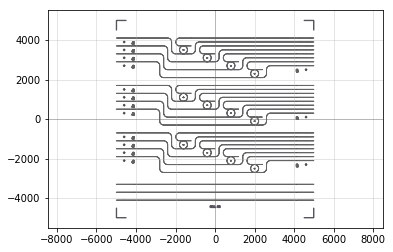

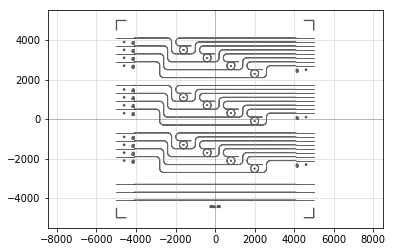

In [20]:
# 
for yy in range(2):
    for xx in range(1):
        CELL_NUM = 2 - 10*xx +yy
        wTp = .9 + yy*.6

        wBus = 1.5
        cellGDS = Device(f'cell{CELL_NUM:02d}')

        # sweep the ring width between groups of devices


        # taper length & taper width, width of bus -> width of taper
        lTp = 500

        devLen = cellW-DIC-2*lTp

        # ring radius
        rRg = 200

        # horizontal and vertical dist. per device
        HD = 6*rRg
        VD = 2*rRg

        gpNum  = 3
        gapPeriod = .02

        for k in range(gpNum):

            wRg = 2.3 + xx*0.5    

            devNum = 4 # num of MRR dev

            # x-axis shift
            offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

            D = Device(f'GP{k}')
            for i in range(devNum):
                gap = gapPeriod*(k*devNum+i) + 0.1
                MRR = D << ext_fourport(width_bus=wBus,
                                  width_rg=wRg,radius=rRg,
                                  gap1=gap,
                                  gap2=gap,
                                  extL=(HD+rRg)*i,
                                  layer=WG_LAY).movex(offset+HD*i).movey(-VD*i)
                D << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY,
                             justify='center').movex(offset+HD*i).movey(-VD*i+rRg)

                # tp port
                CN1 = D << pg.connector((lTp+DIC*.5, MRR.ysize), width=wBus).movey(-VD*i)
                CN2 = D << pg.connector((devLen+lTp+DIC*.5,MRR.ysize-rRg), width=wBus).movey(-VD*i)
                CN3 = D << pg.connector((devLen+lTp+DIC*.5,MRR.ysize), width=wBus).movey(-VD*i)

                TP1 = D << dic_taper(port=CN1.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TP2 = D << dic_taper(port=CN2.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TP3 = D << dic_taper(port=CN3.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)

                RT1 = D << pr.route_manhattan(port1=CN1.ports[1],port2=MRR.ports[1],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT2 = D << pr.route_manhattan(port1=CN2.ports[2],port2=MRR.ports[2],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT3 = D << pr.route_basic(port1=CN3.ports[2],port2=MRR.ports[3],layer=WG_LAY)

                mark1 = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CN1.ports[1]).move((-lTp,-rRg))
                D << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}',
                             layer=LB_LAY, justify='right', size=20).move(CN1.ports[1]).movey(-rRg)
                if i == devNum-1:
                    mark2 = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CN2.ports[1]).move((lTp,-rRg))
                    D << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}',
                             layer=LB_LAY, justify='left', size=20).move(CN2.ports[1]).movey(-rRg)

            cellGDS << D.flatten().movey(VD*(devNum+2)*k)



        def BAR():
            D = Device('BAR')
            wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
            tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            return D.flatten()

        for i in range(3):
            cellGDS << pg.copy(BAR()).movey(-i*VD-1.8e3)


        cellGDS.move(-cellGDS.center)

        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM:02d}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM:02d}.gds')

## spiral

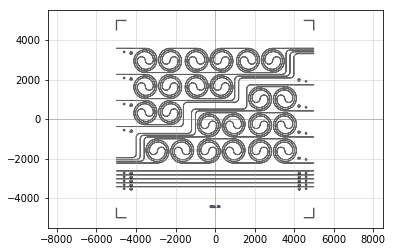

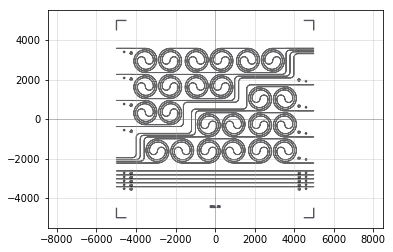

In [7]:
for yy in range(2):
    CELL_NUM = 34 + yy
    cellGDS = Device(f'cell{CELL_NUM}')

    DIS = 90
    BR = 200
    rRg = 200
    wBus = 1.5

    lTp = 400
    wTp = .9 + .6*yy

    devLen = cellW-DIC-2*lTp

    def ext_sp(bent = 20, width = 0.5, n = 1, distance = 10, angle_resolution = 1, layer = 1):
        D = Device('ext_sp')
        AP = D << ph.archimedes(bent=bent,width=width,n=n,distance=distance,angle_resolution=angle_resolution,layer=layer)
        D << pg.taper(port=AP.ports[2],length=AP.xmax+distance/2, layer=layer)
        D << pg.taper(port=AP.ports[1],length=AP.xmax+distance, layer=layer)
        D.xmax = 0
        D << pg.deepcopy(D).reflect((0,1))
        D.add_port(name = 1, midpoint = [D.xmin,D.ymax-width/2], width = width, orientation = 180)
        D.add_port(name = 2, midpoint = [D.xmax,D.ymax-width/2], width = width, orientation = 0)
        return D.flatten()

    doublet = ext_sp(bent=rRg,
                         width=wBus,
                         n=1,
                         distance=DIS,
                         angle_resolution=0.5,
                         layer=WG_LAY)
    doublet.xmin=0
    doublet.ymin=0

    spNum = 4

    extL = devLen-(spNum-1)*doublet.xsize

    def ss(n=1):
        D = Device('ss')
        for i in range(n):
            c1 = pg.connector(midpoint=((doublet.xmax+BR)*i,(doublet.ymax)*i),width=wBus,orientation=0)
            c2 = pg.connector(midpoint=((doublet.xmax+BR)*(i+1),(doublet.ymax)*(i+1)),width=wBus,orientation=0)
            D << pr.route_manhattan(port1=c1.ports[1],port2=c2.ports[2], radius=BR,layer=WG_LAY)
        try:
            D << pg.taper(port=c2.ports[1],width1=wBus,width2=wBus,length=extL-n*BR,layer=WG_LAY)
        except UnboundLocalError:
            D << ph.waveguide(width=wBus,length=extL,layer=WG_LAY)
        return D.flatten()


    def sssp(n=2,spNum=3):
        D = Device('sssp')
        assert n <= spNum
        for i in range(n):
            D << pg.copy(doublet).movex(doublet.xmax*i)
        D << ss(spNum-n).move((doublet.xmax*n,doublet.ymax))
        D.add_port(name = 1, midpoint = [D.xmin,doublet.ymax-wBus/2], width = wBus, orientation = 180)
        D.add_port(name = 2, midpoint = [D.xmax,D.ymax-wBus/2], width = wBus, orientation = 0)
        return D.flatten()


    for i in range(spNum):
        sp_tmp = Device('sp_tmp')
        spU = sp_tmp << sssp(i,spNum-1).movey((doublet.ymax+DIS)*i)
    #     spD = sp_tmp << sssp(i,spNum-1).movey((doublet.ymax+DIS)*i).rotate(180).move((spU.xsize,(doublet.ysize)*spNum))
        tp1 = sp_tmp << dic_taper(port=spU.ports[1],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
        tp2 = sp_tmp << dic_taper(port=spU.ports[2],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
        devL = spU.area()/wBus
        mark = sp_tmp << pg.cross(length=100, width=20, layer=MK_LAY).move(spU.ports[1]).move((-lTp, -2*DIS))
        sp_tmp << pg.text(text=f'L {devL*1e-3:.2f}\nW {wBus}\nTPL {lTp}\nTPW {wTp}', 
                          layer=LB_LAY, justify='right', size=20).move(spU.ports[1]).move((0,-rRg))
    #     LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp}', 
    #                       layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-rRg))

        cellGDS << sp_tmp




    cellGDS.move(-cellGDS.center)
    cellGDS << pg.copy(cellGDS).rotate(180).movey(-doublet.ymax*spNum*.5+900)
    cellGDS.move(-cellGDS.center)

    def BAR(width):
                D = Device('BAR')
                wg =  D << ph.waveguide(length=devLen,width=width, layer=WG_LAY).movex(DIC/2+lTp)
                tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                      width1=width, width2=wTp, layer=TP_LAY)
                tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                      width1=width, width2=wTp, layer=TP_LAY)
                markL = D << pg.cross(length=100, width=20, layer=MK_LAY).move(wg.ports[1]).move((-lTp, -100))
                markR = D << pg.cross(length=100, width=20, layer=MK_LAY).move(wg.ports[2]).move((lTp, -100))
                lbL = D << pg.text(text=f'WB {width:.2f}\nTPL {lTp}\nTPW {wTp}', 
                                  layer=LB_LAY, justify='right', size=20).move(wg.ports[1]).movey(-100)
                lbR = D << pg.text(text=f'WB {width:.2f}\nTPL {lTp}\nTPW {wTp}', 
                                  layer=LB_LAY, justify='left', size=20).move(wg.ports[2]).movey(-100)

                return D.flatten()

    for i in range(5):
        cellGDS << pg.copy(BAR(wBus+i*0.2)).movex(-cellW*.5).movey(-i*200-3.3e3)

    cellGDS.move(-cellGDS.center)

    cellGDS <<  cus_die(size=cellSize, text_size=100,
                             street_length=500, 
                             street_width=20, text_location='S',
                             die_name=f'CELL {CELL_NUM}',
                             draw_bbox=False,
                             layer=MK_LAY)
    qp(cellGDS)
    cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## swing

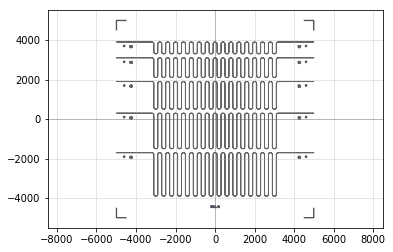

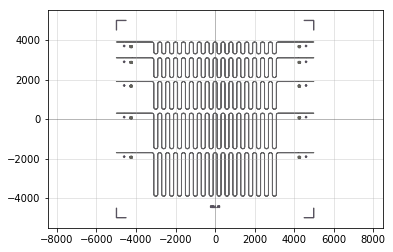

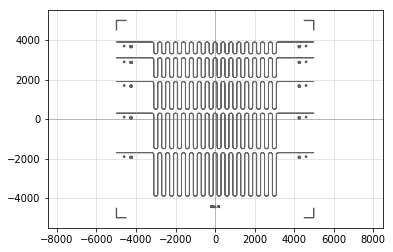

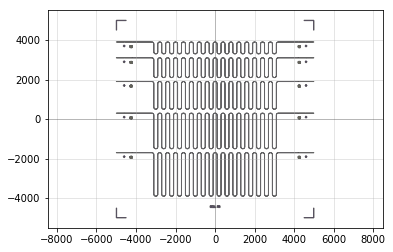

In [8]:
def single_s(width = 1, bent = 50, length = 300, layer = 0):
    D = Device('single_s')
    path = gdspy.Path(width,(0,0)).turn(bent,'r',layer=layer).segment(length,'-y',layer=layer).turn(bent,'ll',layer=layer).segment(length,'+y',layer=layer).turn(bent,'r',layer=layer)
    D.add(path)
    return D
def s_shape(width = 1, num = 10, bent = 50, length = 300, layer = 0):
    D = Device('s_shape')
    for i in range(num):
        D << single_s(width=width,layer=layer,length=length,bent=bent).movex(bent*4*i)
    D.movex(-D.xsize*.5)
    D.add_port(name = 1, midpoint = [D.xmax,D.ymax-width/2], 
               width = width, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymax-width/2], 
               width = width, orientation = 180)
    return D.flatten()


for xx in range(2):
    for yy in range(2):
        CELL_NUM = 11+30*xx+3*yy
        cellGDS = Device(f'cell{CELL_NUM}')
        DIS = 90
        BR = 200
        rRg = 200
        wBus = 1.5 + .5*yy

        lTp = 400
        wTp = .3+.3*xx

        devLen = cellW-DIC-2*lTp
        devNum = 5
        btR = 100
        lStep = 4e2

        for i in range(devNum):
            D = Device('s_shape')

            my = -i*(i+1)*lStep*.5-i*4*btR
            SS = D << s_shape(width = wBus, 
                               num = 16, 
                               length = lStep*(i+1),
                               bent = btR, layer = WG_LAY).movey(my).movex(cellW*.5)
            CNL = D << pg.connector((lTp+DIC*.5,my), width=wBus)
            CNR = D << pg.connector((devLen+lTp+DIC*.5,my), width=wBus)

            TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
            TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                          width1=wBus, width2=wTp, layer=TP_LAY)
            RTL = D << pr.route_basic(port1=CNL.ports[1],port2=SS.ports[2],layer=WG_LAY)
            RTR = D << pr.route_basic(port1=CNR.ports[2],port2=SS.ports[1],layer=WG_LAY)
            lenSS = D.area()/wBus
            markL = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -rRg))
            markR = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -rRg))
            lbL = D << pg.text(text=f'WB {wBus:.2f}\nSSL {lenSS*1e-3:.2f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).movey(-200)
            lbR = D << pg.text(text=f'WB {wBus:.2f}\nSSL {lenSS*1e-3:.2f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).movey(-200)

            cellGDS << D

        cellGDS.move(-cellGDS.center)

        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')


## gc

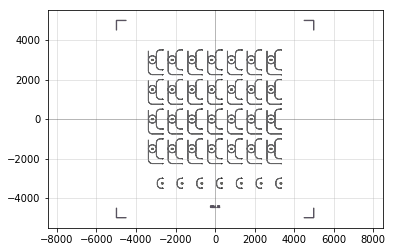

'cell/cell21.gds'

In [40]:
CELL_NUM = 21
cellGDS = Device(f'cell{CELL_NUM}')

rRg = 200
wBus = 1.5
fap = 250


HD = 1e3
VD = 1.5e3
devNum = 7
gpNum = 4

for j in range(gpNum):    
    GP = Device('gp{j}')
    wRg = 1.5 + j*0.5
    for i in range(devNum):
        D = Device('Dev{i}')
        gap = 0.02*(i+6)
        GCi = D << ph.arc_grating(**gcp)
        GCo = D << ph.arc_grating(**gcp).movey(4*fap)
        GCd = D << ph.arc_grating(**gcp).movey(-fap)

        FP = D << ph.fourport(radius=rRg,width_rg=wRg,layer=WG_LAY,gap=gap,
                             width_bus=wBus).rotate(90).move((-2*fap,2*fap))

        RTi = D << pr.route_manhattan(port1=FP.ports[2],port2=GCi.ports[1],radius=rRg,layer=WG_LAY)
        RTo = D << pr.route_manhattan(port1=FP.ports[1],port2=GCo.ports[1],radius=rRg,layer=WG_LAY)
        RTd = D << pr.route_manhattan(port1=FP.ports[4],port2=GCd.ports[1],radius=rRg,layer=WG_LAY)
        TP = D << pg.taper(port=FP.ports[3],length=fap,width1=wBus,width2=0,layer=WG_LAY)
        LBR = D << pg.text(text=f'WRG {wRg:.1f}\nGAP {gap*1e3:.0f}', 
                              layer=LB_LAY, justify='center', size=20).move((-2*fap,2*fap))
        GP << D.movex(i*HD)
    cellGDS << GP.movey(j*VD)

GP = Device('gp_gc')
wRg = 2.5 + j*0.5
for i in range(devNum):
    D = Device('Dev{i}')
    GCi = D << ph.arc_grating(**gcp)
    GCo = D << ph.arc_grating(**gcp).movey(2*fap)
    CN = D << pg.connector((-fap,fap),width=wBus,orientation=90)
    RTi = D << pr.route_manhattan(port1=CN.ports[2],port2=GCi.ports[1],radius=rRg,layer=WG_LAY)
    RTo = D << pr.route_manhattan(port1=CN.ports[1],port2=GCo.ports[1],radius=rRg,layer=WG_LAY)
    ff = gcp['fill_factor']
    pitch = gcp['period']
    LB = D << pg.text(text=f'FF {ff:.2f}\nP {pitch:.2f}', 
                          layer=LB_LAY, justify='center', size=20).move((0,fap))
    GP << D.movex(i*HD)
cellGDS << GP.movey(-VD)

# qp(cellGDS)

cellGDS.move(-cellGDS.center)

cellGDS <<  cus_die(size=cellSize, text_size=100,
                         street_length=500, 
                         street_width=20, text_location='S',
                         die_name=f'CELL {CELL_NUM}',
                         draw_bbox=False,
                         layer=MK_LAY)
qp(cellGDS)
cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

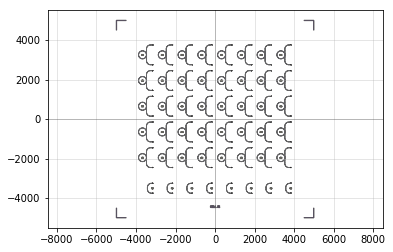

'cell/cell31.gds'

In [39]:
CELL_NUM = 31
cellGDS = Device(f'cell{CELL_NUM}')

rRg = 200
wBus = 1.5
fap = 250

HD = 1e3
VD = 1.3e3
devNum = 8
gpNum = 5

for j in range(gpNum):    
    GP = Device('gp{j}')
    wRg = 1.5 + j*0.5
    for i in range(devNum):
        D = Device('Dev{i}')
        gap = 0.05*(i+2)
        GCi = D << ph.arc_grating(**gcp)
        GCo = D << ph.arc_grating(**gcp).movey(4*fap)

        FP = D << ph.allpass(radius=rRg,width_rg=wRg,layer=WG_LAY,gap=gap,
                             width_bus=wBus).rotate(90).move((-2*fap,2*fap))

        RTi = D << pr.route_manhattan(port1=FP.ports[2],port2=GCi.ports[1],radius=rRg,layer=WG_LAY)
        RTo = D << pr.route_manhattan(port1=FP.ports[1],port2=GCo.ports[1],radius=rRg,layer=WG_LAY)
#         RTd = D << pr.route_manhattan(port1=FP.ports[4],port2=GCd.ports[1],radius=rRg,layer=WG_LAY)
#         TP = D << pg.taper(port=FP.ports[3],length=fap,width1=wBus,width2=0,layer=WG_LAY)
        LBR = D << pg.text(text=f'WRG {wRg:.1f}\nGAP {gap*1e3:.0f}', 
                              layer=LB_LAY, justify='center', size=20).move((-2*fap,2*fap))
        GP << D.movex(i*HD)
    cellGDS << GP.movey(j*VD)

GP = Device('gp_gc')
wRg = 2.5 + j*0.5
for i in range(devNum):
    D = Device('Dev{i}')
    gap = 0.1*(i+1)
    GCi = D << ph.arc_grating(**gcp)
    GCo = D << ph.arc_grating(**gcp).movey(2*fap)
    CN = D << pg.connector((-fap,fap),width=wBus,orientation=90)
    RTi = D << pr.route_manhattan(port1=CN.ports[2],port2=GCi.ports[1],radius=rRg,layer=WG_LAY)
    RTo = D << pr.route_manhattan(port1=CN.ports[1],port2=GCo.ports[1],radius=rRg,layer=WG_LAY)
    ff = gcp['fill_factor']
    pitch = gcp['period']
    LB = D << pg.text(text=f'FF {ff:.2f}\nP {pitch:.2f}', 
                          layer=LB_LAY, justify='center', size=20).move((0,fap))
    GP << D.movex(i*HD)
cellGDS << GP.movey(-VD)

# qp(cellGDS)

cellGDS.move(-cellGDS.center)

cellGDS <<  cus_die(size=cellSize, text_size=100,
                         street_length=500, 
                         street_width=20, text_location='S',
                         die_name=f'CELL {CELL_NUM}',
                         draw_bbox=False,
                         layer=MK_LAY)
qp(cellGDS)
cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## asym mrr

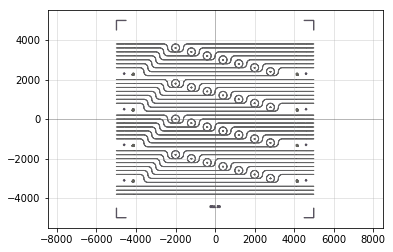

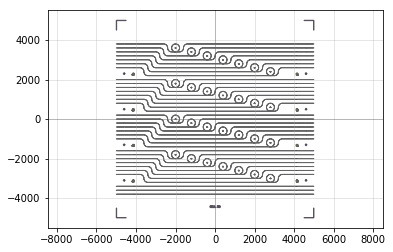

In [32]:

# ring composed of two unconcentric round
def asym_ring(dx = .2, radius = 10, width = 0.5, angle_resolution = 1, layer = 0):
    assert dx < width
    D = Device(name = 'new_ring')
    inner_radius = radius - width/2
    outer_radius = radius + width/2
    angle = np.arange(0, 360+angle_resolution, angle_resolution)
    angle.sort()
    t=angle*np.pi/180
    inner_points_x = (inner_radius*np.cos(t)+dx).tolist()
    inner_points_y = (inner_radius*np.sin(t)).tolist()
    outer_points_x = (outer_radius*np.cos(t)).tolist()
    outer_points_y = (outer_radius*np.sin(t)).tolist()
    xpts = inner_points_x + outer_points_x[::-1]
    ypts = inner_points_y + outer_points_y[::-1]
    D.add_polygon(points = (xpts,ypts), layer = layer)
    return D

def asym_allpass(width_rg=1, width_bus=1, dx = 0.1, radius=30, gap=0.1, layer=0):
    D = Device('asym_allpass')
    RG = D << asym_ring(dx = dx, radius=radius,width=width_rg, layer=layer) 
    BUS = D << ph.waveguide(length=2*radius+width_rg,width=width_bus, layer=layer).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D

def ext_asym_allpass(width_rg=1, width_bus=1, dx = 0.1, radius=30, gap=0.1,lenL=10,lenR=10 ,layer = 0):
    D = Device('ext_asym_allpass')
    RG = D << asym_ring(dx=dx, radius=radius,width=width_rg, angle_resolution=.1,layer = layer)
    BUS = D << ph.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus,layer = layer).movex(-radius-(width_rg)/2-lenL)
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D

for xx in range(2):
    for yy in range(1):
        wBus = 1.5
        CELL_NUM = 20+10*xx+yy
        wTp = .3 + yy*.3
        cellGDS = Device(f'cell{CELL_NUM}')

        # sweep the ring width between groups of devices

        devLen = cellW-DIC-2*lTp

        # ring radius
        rRg = 200

        # horizontal and vertical dist. per device
        HD = 4*rRg
        VD = rRg

        gpNum  = 4
        gapPeriod = .05

        for k in range(gpNum):

            wRg = 2.0
            DX = 0.2*(k+1+gpNum*xx)  

            devNum = 7 # num of MRR dev

            # x-axis shift
            offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

            D = Device(f'GP{k}')
            LB = Device(f'LB{k}')

            for i in range(devNum):
                gap = gapPeriod*i+0.1
                MRR = D << ext_asym_allpass(
                    dx = DX,
                    width_bus=wBus,
                    width_rg=wRg,radius=rRg,
                    gap=gap,
                    lenL=i*HD+i*rRg,
                    lenR=0,
                    layer=WG_LAY).move((offset+HD*i,-VD*i))
                LB << pg.text(text=f'DX {DX:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

                # tp port
                CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
                CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

                TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)

            #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
                RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                              bendType='circular',radius=rRg,layer=WG_LAY)

            markNum = 1
            markDist = 300
            markSize = 100
            markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -1.5*rRg))
            markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-1.5*rRg))
            D << LB
            cellGDS << D.flatten().movey(VD*(devNum+2)*k)

        def BAR():
            D = Device('BAR')
            wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
            tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            return D.flatten()

        for i in range(3):
            cellGDS << pg.copy(BAR()).movey(-i*VD-1.6e3)


        cellGDS.move(-cellGDS.center)

        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## comb mrr

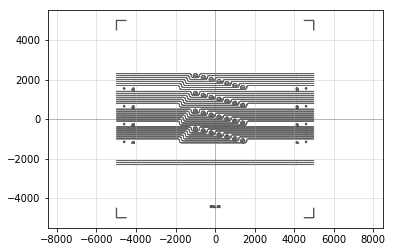

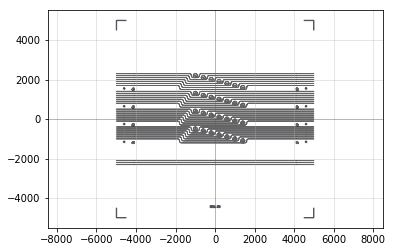

In [25]:
def comb_ring(radius = 100., width = 2, amp_factor = 0.02, tooth_num = 100,layer = 0):
    D = Device(name = 'comb_ring')
    angle_resolution = 10/radius
    inner_radius_int = radius - width*.5
    outer_radius = radius + width*.5
    angle = np.arange(0, 360+angle_resolution, angle_resolution)
    angle.sort()
    t=angle*np.pi/180
    inner_radius = inner_radius_int + width*amp_factor*np.cos(t*tooth_num)
    inner_points_x = (inner_radius*np.cos(t)).tolist()
    inner_points_y = (inner_radius*np.sin(t)).tolist()
    outer_points_x = (outer_radius*np.cos(t)).tolist()
    outer_points_y = (outer_radius*np.sin(t)).tolist()
    xpts = inner_points_x + outer_points_x[::-1]
    ypts = inner_points_y + outer_points_y[::-1]
    D.add_polygon(points = (xpts,ypts), layer = layer)
    return D


def ext_comb_allpass(width_rg=1, width_bus=1, amp_factor = 0.002, tooth_num = 360, radius=30, gap=0.1,lenL=10,lenR=10 ,layer = 0):
    D = Device('ext_comb_allpass')
    RG = D << comb_ring(amp_factor = amp_factor, tooth_num = tooth_num, radius=radius,width=width_rg,layer = layer)
    BUS = D << ph.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus,layer = layer).movex(-radius-(width_rg)/2-lenL)
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D

for xx in range(1):
    for yy in range(2):
        wBus = 1.5
        CELL_NUM = 52+10*xx+yy
        wTp = .9
        cellGDS = Device(f'cell{CELL_NUM}')

        # sweep the ring width between groups of devices

        devLen = cellW-DIC-2*lTp

        # ring radius
        rRg = 100

        # horizontal and vertical dist. per device
        HD = 4*rRg
        VD = rRg

        gpNum  = 4
        gapPeriod = .05
        Nlist = [424,212,106,53]
        for k in range(gpNum):

            wRg = 2.0
            amp_factor = 0.1*(k+1)
            comb = Nlist[k]
            devNum = 7 # num of MRR dev

            # x-axis shift
            offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

            D = Device(f'GP{k}')
            LB = Device(f'LB{k}')

            for i in range(devNum):
                gap = gapPeriod*i+0.1
                MRR = D << ext_comb_allpass(
                    amp_factor = amp_factor, tooth_num = comb,
                    width_bus=wBus,
                    width_rg=wRg,radius=rRg,
                    gap=gap,
                    lenL=i*HD+i*rRg,
                    lenR=0,
                    layer=WG_LAY).move((offset+HD*i,-VD*i))
                LB << pg.text(text=f'N {comb}\nGAP {1e3*gap:.0f}', layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

                # tp port
                CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
                CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

                TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)

            #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
                RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                              bendType='circular',radius=rRg,layer=WG_LAY)

            markNum = 1
            markDist = 300
            markSize = 100
            markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -1.5*rRg))
            markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nTPL {lTp}\nTPW {wTp}', 
                              layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-1.5*rRg))
            D << LB
            cellGDS << D.flatten().movey(VD*(devNum+2)*k)

        def BAR():
            D = Device('BAR')
            wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
            tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            return D.flatten()

        for i in range(3):
            cellGDS << pg.copy(BAR()).movey(-i*VD-1.6e3)


        cellGDS.move(-cellGDS.center)

        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## radius sweepin

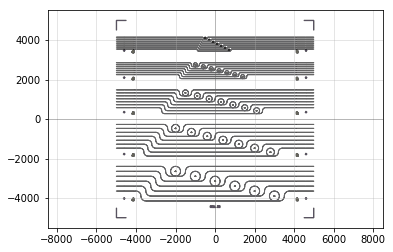

In [14]:
for xx in range(1):
    for yy in range(1):
        wBus = 1.5
        CELL_NUM = 22+10*xx+yy
        wTp = .3 + xx*.3
        cellGDS = Device(f'cell{CELL_NUM}')

        # sweep the ring width between groups of devices

        devLen = cellW-DIC-2*lTp



        gpNum  = 5
        gapPeriod = .05

        for k in range(gpNum):
            # ring radius
            rRg = 50 + k*50

            # horizontal and vertical dist. per device
            HD = 4*rRg
            VD = max(rRg, 100)

            wRg = 2.0 + .8*yy + .2*k    

            if k < 4:  
                devNum = 7 # num of MRR dev
            else:
                devNum = 6
            # x-axis shift
            offset = devLen/2 - devNum*HD/2 + rRg*4 + DIC/2 +lTp

            D = Device(f'GP{k}')
            LB = Device(f'LB{k}')

            for i in range(devNum):
                gap = gapPeriod*i+0.1
                MRR = D << ext_allpass(width_bus=wBus,
                                   width_rg=wRg,radius=rRg,
                                   gap=gap,
                                   lenL=i*HD+i*rRg,
                                   lenR=0,
                                  layer=WG_LAY).move((offset+HD*i,-VD*i))
                LB << pg.text(text=f'WRG {wRg:.1f}\nGAP {1e3*gap:.0f}', layer=LB_LAY, justify='center').move((offset+HD*i,-VD*i))

                # tp port
                CNL = D << pg.connector((lTp+DIC*.5,rRg-VD*i), width=wBus)
                CNR = D << pg.connector((devLen+lTp+DIC*.5,rRg-VD*i), width=wBus)

                TPL = D << dic_taper(port=CNL.ports[2],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)
                TPR = D << dic_taper(port=CNR.ports[1],length=lTp,dicL=DIC/2,
                              width1=wBus, width2=wTp, layer=TP_LAY)

            #     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
                RT1 = D << pr.route_manhattan(port1=CNL.ports[1],port2=MRR.ports[2],
                                              bendType='circular',radius=rRg,layer=WG_LAY)
                RT2 = D << pr.route_manhattan(port1=CNR.ports[2],port2=MRR.ports[1],
                                              bendType='circular',radius=rRg,layer=WG_LAY)

            markNum = 1
            markDist = 300
            markSize = 100
            markLeft = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNL.ports[1]).move((-lTp, -1.5*rRg))
            markRight = D << pg.cross(length=100, width=20, layer=MK_LAY).move(CNR.ports[1]).move((lTp, -1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp:.1f}', 
                              layer=LB_LAY, justify='right', size=20).move(CNL.ports[1]).move((0,-1.5*rRg))
            LB << pg.text(text=f'R {rRg:.0f}\nWB {wBus:.2f}\nWRG {wRg:.1f}\nTPL {lTp}\nTPW {wTp:.1f}', 
                              layer=LB_LAY, justify='left', size=20).move(CNR.ports[2]).move((0,-1.5*rRg))
            D << LB
            D.ymax = cellGDS.ymin - 500
            cellGDS << D.flatten()
#             D.movey(cellGDS.ysize)

        def BAR():
            D = Device('BAR')
            wg =  D << ph.waveguide(length=devLen,width=wBus, layer=WG_LAY).movex(DIC/2+lTp)
            tp1 = D << dic_taper(port=wg.ports[1],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            tp2 = D << dic_taper(port=wg.ports[2],length=lTp,dicL=DIC/2,
                                  width1=wBus, width2=wTp, layer=TP_LAY)
            return D.flatten()

#         for i in range(3):
#             cellGDS << pg.copy(BAR()).movey(-i*VD-1.6e3)


        cellGDS.move(-cellGDS.center)

        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {CELL_NUM}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        qp(cellGDS)
        cellGDS.write_gds('view.gds')
#         cellGDS.flatten().write_gds(f'cell/cell{CELL_NUM}.gds')

## generator

In [33]:
waferGDS = Device('waferGDS')

for x in range(6):
    for y in range(6):
#         cellFile = f'cell11.gds'
        cellFile = f'cell/cell{x}{y}.gds'
        try:
            waferGDS << pg.import_gds(filename=cellFile,flatten=True).move((cellW*(x-2.5),cellH*(y-2.5)))
        except FileNotFoundError:
            pass
        
pg.copy(waferGDS).flatten().write_gds('flat_ntt.gds')

waferGDS << pg.ring(radius=65e3*.5,layer=5)
waferGDS << pg.ring(radius=100e3*.5,layer=5)

# waferGDS << pg.bbox( ((0,0),(1e3,1e3)) )
waferGDS.write_gds('view_ntt.gds')


'view_ntt.gds'

In [63]:
%cd cell/ 
%copy cell00.gds cell30.gds
%cd ..

C:\Users\fibom\Documents\GDS\190924-NTT\cell
        1 file(s) copied.
C:\Users\fibom\Documents\GDS\190924-NTT


In [34]:
for i in range(6):
    for j in range(6):
        cellGDS = Device('NA')
        cellGDS <<  cus_die(size=cellSize, text_size=100,
                                 street_length=500, 
                                 street_width=20, text_location='S',
                                 die_name=f'CELL {i}{j}',
                                 draw_bbox=False,
                                 layer=MK_LAY)
        cellGDS.flatten().write_gds(f'cell/cell{i}{j}.gds')

## playground

In [154]:
np.arange(0,10,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

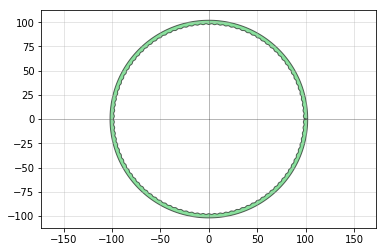

'view.gds'

In [156]:
from phidl.geometry import *

# ring composed of two unconcentric round
# @device_lru_cache
def comb_ring(radius = 100., width = 2, amp_factor = 0.02, tooth_num = 100,layer = 0):
    D = Device(name = 'comb_ring')
    angle_resolution = 10/radius
    inner_radius_int = radius - width*.5
    outer_radius = radius + width*.5
    angle = np.arange(0, 360, angle_resolution)
    angle.sort()
    t=angle*np.pi/180
    inner_radius = inner_radius_int + width*amp_factor*np.cos(t*tooth_num)
    inner_points_x = (inner_radius*np.cos(t)).tolist()
    inner_points_y = (inner_radius*np.sin(t)).tolist()
    outer_points_x = (outer_radius*np.cos(t)).tolist()
    outer_points_y = (outer_radius*np.sin(t)).tolist()
    xpts = inner_points_x + outer_points_x[::-1]
    ypts = inner_points_y + outer_points_y[::-1]
    D.add_polygon(points = (xpts,ypts), layer = layer)
    return D


D = Device('test')

D << comb_ring(radius=100.,amp_factor=0.1,width=4.,tooth_num=106)

qp(D)

D.flatten().write_gds('view.gds')

In [ ]:
def arc_tapered(radius = 10, width1 = 1, width2 = 2, theta = 45, angle_resolution = 2.5, layer = 0):
    D = Device('arctaper')
    path1 = gdspy.Path(width = width1, initial_point = (0, 0))
    path1.turn(radius = radius, angle = theta*np.pi/180, number_of_points=int(abs(2*theta/angle_resolution)), final_width = width2)
    [D.add_polygon(p, layer = layer) for p in path1.polygons]
    D.add_port(name = 1, midpoint = (0, 0), width = width1, orientation = 180)
    D.add_port(name = 2, midpoint = (path1.x, path1.y), width = width2, orientation = path1.direction*180/np.pi)
    return D

def mrr3pH(width_rg=2, width_bus=1, radius=30, gap1=0.1, gap2=0.1, layer=0):
    D = Device('mrr3p')
    RG = D << ph.ring(radius=radius,width=width_rg, layer=layer).movey(radius)
    BUS = D << ph.waveguide(length=2*radius, width=width_bus, layer=layer).rotate(90)
    RG.xmin = BUS.xmax + gap1
    BT1 = D << pg.turn(angle=90,port=BUS.ports[1],radius=radius,layer=layer)
    BT2 = D << pg.turn(angle=90,port=BUS.ports[2],radius=radius,layer=layer)
    ET1 = D << pg.taper(port=BT1.ports[2],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    BT2 = D << pg.turn(angle=90,port=ET1.ports[2],radius=radius,layer=layer)
    ET2 = D << pg.taper(port=BT2.ports[2],length=radius,width1=width_bus,width2=width_bus,layer=layer)
    BT3 = D << pg.turn(angle=-90,port=ET2.ports[2],radius=radius,layer=layer)
    CN1 = D << pg.connector((0,0),width=0, orientation=90)
    CN2 = D << pg.connector((0,2*radius),width=width_bus,orientation=90)
    RT1 = D << pr.route_basic(port1=CN1.ports[1],port2=CN2.ports[2],layer=layer)
    RT1.movex(2*radius+gap1+gap2+width_rg+width_bus)
    BT4 = D << pg.turn(angle=-90,port=RT1.ports[2],radius=radius,layer=layer)
    
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D



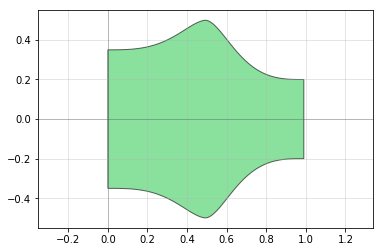

In [92]:
D = Device('ee')

def drum(width1 = .6, width2 = 1.3, width3 = .4, length=1, ef = 3, layer = 0, resolution = .01):
    D = Device('DRUM')
    assert ef%2 == 1
    x1 = np.arange(0,length*.5,resolution)
    y1 = np.array([width1*.5 + (width2*.5-width1*.5)*np.sin(np.pi*.5*(x/length*2)**ef) for x in x1])
    x2 = x1 + length*.5
    y2 = np.array([width3*.5 + (width2*.5-width3*.5)*np.sin(np.pi*.5*(x/length*2)**ef) for x in x1])[::-1]
    x3 = x2[::-1]
    y3 = -y2[::-1]
    x4 = x1[::-1]
    y4 = -y1[::-1]
    xpts = x1.tolist() + x2.tolist() + x3.tolist() + x4.tolist()
    ypts = y1.tolist() + y2.tolist() + y3.tolist() + y4.tolist()
    D.add_polygon(points = (xpts,ypts), layer = layer)

#     CN1 = pg.connector(midpoint=(0,0),width=width1)
#     CN2 = pg.connector(midpoint=(length*.5,0),width=ef)
#     CN3 = pg.connector(midpoint=(length,0),width=width2)
#     D << pr.route_basic(port1=CN1.ports[1],port2=CN2.ports[2], layer=layer,path_type = 'sine', width_type = 'sine',)
#     D << pr.route_basic(port1=CN2.ports[1],port2=CN3.ports[2], layer=layer,path_type = 'sine', width_type = 'sine',)
    
    return D.flatten()
NUM = 30
D << drum(length=1,width1=.7,width2=1,ef=3)#width1=width[i],width2=width[i+1],ef=2+.1*i).movex(i)

qp(D)

In [18]:
D = Device('CJC')
LB_CEL = Device('LB_CEL')

def ext_allpass(width_rg=1, width_bus=1, radius=30, gap=0.1,lenL=10,lenR=10):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg, angle_resolution=.1)
    BUS = D << ph.waveguide(length=2*radius+lenL+lenR+width_rg,
                            width=width_bus).movex(-radius-(width_rg)/2-lenL)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], 
               width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], 
               width = width_bus, orientation = 180)
    return D
w = 1.5 # width of
wBus = 1.5
wRg = w
# wTp = 0.2

devLen = 10000
rRg = 100

HD = 4*rRg
VD = rRg*.8
num = 8 # num of MRR

gapPeriod = .05
offset = devLen/2 - num*HD/2
# margin = 100

for i in range(num):
    gap = gapPeriod*i+0.1
    MRR = D << ext_allpass(width_bus=wBus,
                       width_rg=wRg,radius=rRg, 
                       gap=gap,
                       lenL=i*HD+i*rRg,
                       lenR=0).move((offset+HD*i,-VD*i))
    LB_CEL << pg.text(text='GAP%d' % (1e3*gap), layer=2, justify='right').move((offset+HD*i,-VD*i))
    TPCL = D << pg.connector((0,rRg-VD*i),width=wBus)
    TPCR = D << pg.connector((devLen,rRg-VD*i),width=wBus)
#     MIDL = D << pg.connector((MRR.xmin-margin,(MRR.ymin+rRg)),width=wBus)
    RT1 = D << pr.route_manhattan(port1=TPCL.ports[1],port2=MRR.ports[2],
                                  bendType='circular',radius=rRg)
    RT2 = D << pr.route_manhattan(port1=TPCR.ports[2],port2=MRR.ports[1],
                                  bendType='circular',radius=rRg)

mark = [pg.rectangle((100,100), layer=2).move((300*i,-(num)*VD)) for i in range(5)]
mark2 = [pg.rectangle((100,100), layer=2).move((devLen-300*i-100,-(num)*VD)) for i in range(5)]

bar =  ph.waveguide(length=devLen,width=wBus).move((0,-(num+1)*VD))
for i in range(3):
    D << pg.copy(bar).movey(-i*VD)
    
D_out = pg.outline(D, distance=10, layer=1)

for i in (D, D_out):
    i << LB_CEL
    i << tuple(mark)
    i << tuple(mark2)

D.rotate(90)
# D_out.flatten().write_gds('190807-nanofab-mrr-nega.gds')
# D.flatten().write_gds('190807-nanofab-mrr-posi.gds')

Device (name "CJC" (uid 7676),  ports [], aliases [], 0 polygons, 54 references)

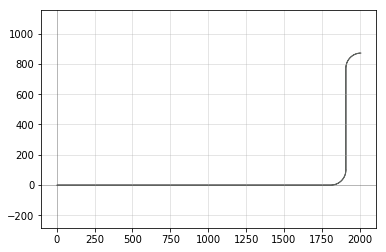

In [168]:
D = Device('bus')

def ss():
    D = Device('ss')
    c1 = pg.connector(midpoint=(0,0),width=1,orientation=0)
    c2 = pg.connector(midpoint=(doublet.xmax,doublet.ymax),width=5,orientation=0)
    D << pr.route_manhattan(port1=c1.ports[1],port2=c2.ports[2], radius=100)
    return(D)

D << ss()

qp(D)

# D.flatten().write_gds('view.gds')

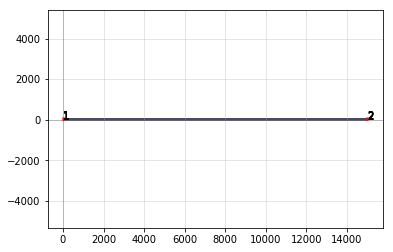

'templates/trench.gds'

In [78]:
# create trenches to test etching rate
D = Device('trench')

w_l = [0.2,0.3,0.4,0.6,1,2,5,10]

mx = 0
for i in range(len(w_l)):
    mx += (w_l[i] + 5)
#     print(mx)
    D << ph.waveguide(width=w_l[i],length=15e3, layer=1).movey(mx)

qp(D)
D.write_gds('templates/trench.gds')

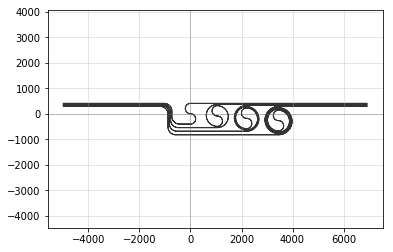

In [14]:
D = Device('SEMI')
D_b = Device('lb')
width = 1.5
xs = 50
ys = 90
for i in range(4):
    CEL = Device('CEL')
    foo = 1e3+i*xs
    SS = CEL << ph.semi_spiral(bend=430,shift=xs,width=width,layer=1, n=i).move((foo*i,-ys*i))
    EXR = CEL << ph.extend(port=SS.ports[2],length=6.5e3-(foo+xs)*i)
    EXL = CEL << ph.extend(port=SS.ports[1],length=(foo)*i)
    CN = pg.connector((-5e3,SS.ports[2].midpoint[1]),width,orientation=0)
    CEL << pr.route_manhattan(CN.ports[1],EXL.ports[2],bendType='circular',radius=300)    
    L = CEL.area()/width
    D_b << pg.text(text='WL%.2f'% L, position=((foo*i,100-ys*i)))
    D << CEL
#       D.area()/width

D_out = pg.outline(D,distance=10)
D_out << D_b

D_out.flatten().write_gds('templates/semicircle-spiral_align.gds')
qp(D)

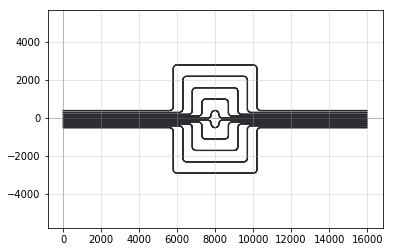

In [61]:
D = Device('array')

def swing(length=1.3e3, height=100, bend=200):
    D = Device('swing')
    subL = length - height - 2*bend
    assert subL > 100
    WG1 = D << ph.waveguide(length=subL,width=1.5)
    BD1 = D << pg.turn(port=WG1.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG2 = D << ph.extend(port=BD1.ports[2],length=height)
    BD2 = D << pg.turn(port=WG2.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG3 = D << ph.extend(port=BD2.ports[2],length=2*height)
    BD3 = D << pg.turn(port=WG3.ports[2],angle=-90,radius=bend,angle_resolution=1)
    WG4 = D << ph.extend(port=BD3.ports[2],length=height)
    BD4 = D << pg.turn(port=WG4.ports[2],angle=90,radius=bend,angle_resolution=1)
    WG5 = D << ph.extend(port=BD4.ports[2],length=subL)
    return D
# arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)

for i in range(5):
    D << swing(length=8e3,height=i*500).movey(i*100)
#     D << swing(height=200).movey(50)
#     D << swing(height=300).movey(100)

D << pg.copy(D).rotate(180).move((16e3,-100))
D_out = pg.outline(D.flatten(), distance=8, layer=1) 
# D.flatten().write_gds('swing_array.gds')
qp(D_out)
D_out.write_gds('180409_swing_posi_1500.gds')

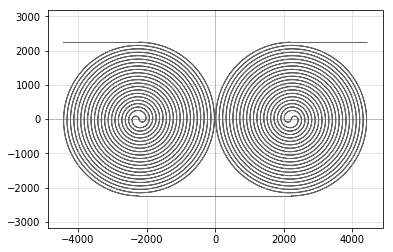

In [7]:
D = Device('archemedes_spiral')
D_b = Device('label')

width = 1.5
xs = 50
ys = 90
kw = {'width': 1.5,
     'layer': 1,
     'angle_resolution': 0.5}

AP = Device('unit_ap')
APC = AP << ph.archimedes(n=10,**kw,bent=100,distance=100)
APR = AP << ph.extend(port=APC.ports[2],length=APC.xmax+20)
APL = AP << ph.extend(port=APC.ports[1],length=APC.xmax+20)
AP.xmax=0
APsym = pg.copy(AP).reflect([0,0], [0,1])
APsym.xmin=0
AP << APsym 
D << AP

def add_asp():
    global AP
    APcopy = pg.copy(AP)
    APcopy.xmin=AP.xmax
    AP = APcopy
    return D << APcopy

# add_asp()
# add_asp()
D_out = pg.outline(D,distance=16,layer=31)
D_out << D_b

D_out.flatten().write_gds('archemedes_spiral.gds')
qp(D)

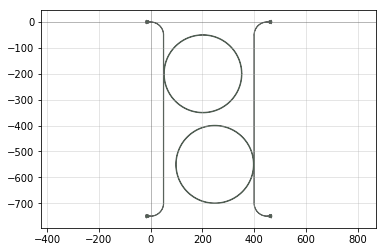

In [4]:
D = Device('PG')

args = {'width': 1}
pitch = 250*3

WG = Device('WG')
bt1 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(90).move((0,-50))
WG << ph.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args)

bt2 = WG << pg.arc(radius=50,start_angle=0,theta=90,**args).rotate(180).move((0,50-pitch))
WG << ph.arc_grating(num_periods = 20, period = 0.64, fill_factor = 29/64, angle = 45, length_taper = 5,**args).movey(-pitch)

bus = WG << pr.route_basic(port1=bt2.ports[1],port2=bt1.ports[2])

WG1 = D << pg.copy(WG).reflect([0,0], [0,1])
WG2 = D << pg.copy(WG).movex(450)

rg = pg.ring(150, 2).movey(-200)

RG1 = D << pg.copy(rg)
RG1.xmin = WG1.xmax + 0.4

RG2 = D << pg.copy(rg).movey(-350)
RG2.xmax = WG2.xmin - 0.5


# D_out = pg.outline(D, distance = 14)


qp(D)
# qp(D_out)
# D_out.write_gds('arc_gc.gds')
# D.xmax-D.xmin
# D.write_gds('arc_graitng.gds')

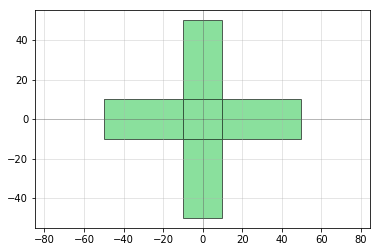

'view.gds'

In [15]:
D = Device('AD-MRR')

# D << pg.compass_multi(size=(10,10))
D << pg.cross(length=100,width=20)
# D << pg.taper()
qp(D)

D.write_gds('view.gds')

In [193]:
?pg.tee

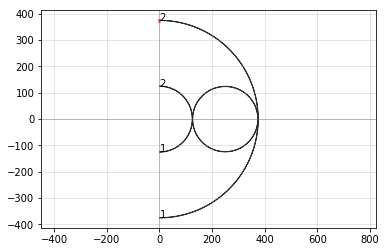

In [5]:
D = Device('AD-MRR')

w = 1
pitch = 250
gap = 0

ra1 = pitch/2
ra2 = 3*pitch/2
r = (ra2 - ra1)/2 - gap - w

args = {'width': w,
        'layer': 0}
arc1 = D << pg.arc(radius=ra1,start_angle=-90,theta=180,**args)
arc2 = D << pg.arc(radius=ra2,start_angle=-90,theta=180,**args)
rg = D << ph.ring(radius=r,**args,angle_resolution=1).move((r+ra1+gap+w,0))

# bus = D << ph.waveguide(length=100,**args)

# D << pg.deepcopy(bus) 
qp(D)

D.write_gds('templates/AD-MRR.gds')

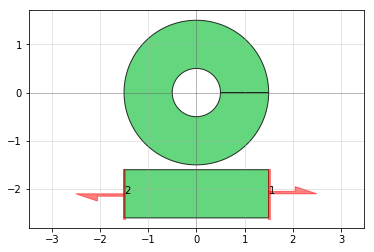

In [16]:
def allpass(width_rg=1, width_bus=1, radius=30, gap=0.1):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg) 
    BUS = D << ph.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS.ymax = RG.ymin - gap
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    return D

def fourport(width_rg=1, width_bus=1, radius=30, gap=0.1):
    D = Device('MRRBUS')
    RG = D << pg.ring(radius=radius,width=width_rg) 
    BUS1 = D << ph.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    BUS2 = D << ph.waveguide(length=2*radius+width_rg,width=width_bus).movex(-radius-width_rg/2)
    # align ring & bus, rotate
    BUS1.ymax = RG.ymin - gap
    BUS2.ymin = RG.ymax + gap    
    D.add_port(name = 1, midpoint = [D.xmax,D.ymin+width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 2, midpoint = [D.xmin,D.ymin+width_bus/2], width = width_bus, orientation = 180)
    D.add_port(name = 3, midpoint = [D.xmax,D.ymax-width_bus/2], width = width_bus, orientation = 0)
    D.add_port(name = 4, midpoint = [D.xmin,D.ymax-width_bus/2], width = width_bus, orientation = 180)
    return D

# def fourport()

D = Device('view')
D << allpass(radius=1)
qp(D)
# D.write_gds('view.gds')

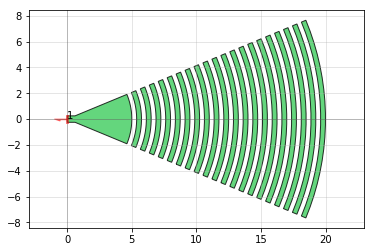

In [3]:
D = Device('PG')

D << pg.arc(radius=10,start_angle=0,theta=90,width=2)
D << ph.arc_grating()
qp(D)
D.write_gds('arc_gc.gds')
# D.write_gds('arc_graitng.gds')

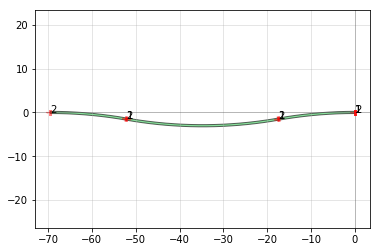

In [47]:
D = Device('bus')

wg1 = D << pg.connector(width=0.5)
arc1 = D << pg.turn(wg1.ports[2],angle=10,radius=100,angle_resolution=1)
arc2 = D << pg.turn(arc1.ports[2],angle=-20,radius=100,angle_resolution=1)
arc3 = D << pg.turn(arc2.ports[2],angle=10,radius=100,angle_resolution=1)
# wg2 = D << waveguide(0.5,20)
qp(D)
# D.write_gds('view.gds')

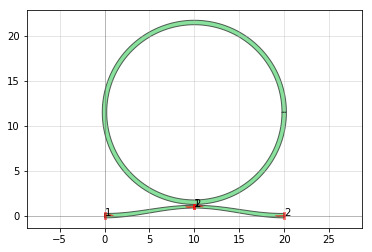

'view.gds'

In [34]:
D = Device('bus')

# gt1 = D << ph.arc_grating().rotate(180)
a1 = pg.connector((0,0),0.5)
a2 = pg.connector((10,1),0.3)
a3 = pg.connector((20,0),0.5)

w1 = D << pr.route_basic(port1=a1.ports[2],port2=a2.ports[1])
w2 = D << pr.route_basic(port1=a2.ports[2],port2=a3.ports[1])
rg = D << pg.ring(radius=10, width=0.5).move((10,12))

rg.ymin = w1.ymax + 0.1
qp(D)
D.write_gds('view.gds')